# Dataset Cleaning
This notebook pollutes a train set by randomly flipping labels, then prioritizes train instances to check to fix them.

In [1]:
import os
import sys
sys.path.insert(0, os.getcwd() + '/../')  # for scripts
sys.path.insert(0, os.getcwd() + '/../../')  # for util

from scripts.cleaning import noise_detection
data_dir = '../../data'

## Amazon

train instances: 26215
test instances: 6554
sum before: 24711
ones flipped: 9871
zeros flipped: 615
sum after: 15455
num noisy labels: 10486

Before noise:
model (CatBoostClassifier)
train set acc: 0.946176
train log loss: 0.16173
train auroc: 0.873
test set acc: 0.941562
test log loss: 0.18010
test auroc: 0.820

After noise:
model (CatBoostClassifier)
train set acc: 0.619111
train log loss: 0.64896
train auroc: 0.657
test set acc: 0.883583
test log loss: 0.55343
test auroc: 0.547


100%|██████████| 10/10 [00:10<00:00,  1.05it/s]


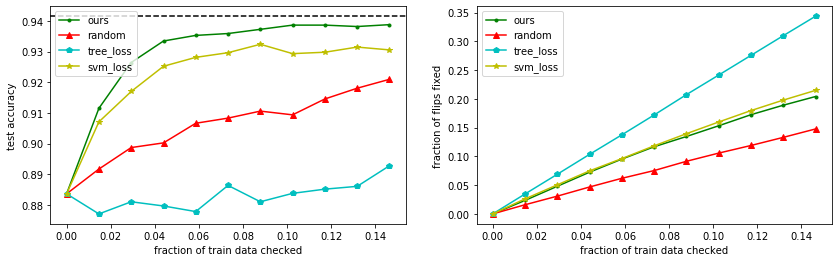

In [2]:
noise_detection(model_type='cb', encoding='leaf_output', dataset='amazon', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True, flip_frac=0.4)

## Adult

train instances: 32561
test instances: 16281
sum before: 7841
ones flipped: 2998
zeros flipped: 10026
sum after: 14869
num noisy labels: 13024

Before noise:
model (CatBoostClassifier)
train set acc: 0.882590
train log loss: 0.26534
train auroc: 0.937
test set acc: 0.868313
test log loss: 0.28596
test auroc: 0.923

After noise:
model (CatBoostClassifier)
train set acc: 0.607997
train log loss: 0.65584
train auroc: 0.654
test set acc: 0.806277
test log loss: 0.59129
test auroc: 0.826


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


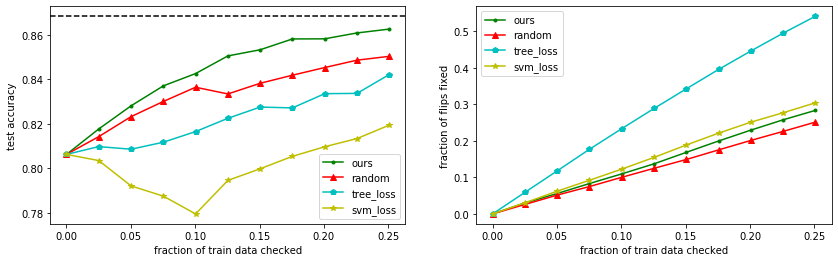

In [3]:
noise_detection(model_type='cb', encoding='leaf_output', dataset='adult', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True, flip_frac=0.4)

## Churn

train instances: 5634
test instances: 1409
sum before: 1495
ones flipped: 520
zeros flipped: 1451
sum after: 2426
num noisy labels: 1971

Before noise:
model (CatBoostClassifier)
train set acc: 0.843983
train log loss: 0.34169
train auroc: 0.905
test set acc: 0.802697
test log loss: 0.43637
test auroc: 0.831

After noise:
model (CatBoostClassifier)
train set acc: 0.698083
train log loss: 0.59689
train auroc: 0.777
test set acc: 0.724627
test log loss: 0.58884
test auroc: 0.719


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


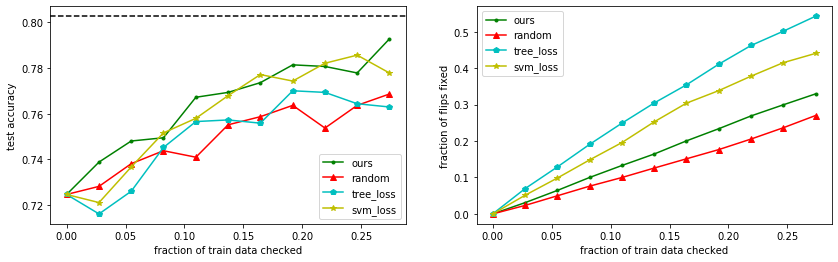

In [4]:
noise_detection(model_type='cb', encoding='leaf_path', dataset='churn', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True, flip_frac=0.35, true_label=False)

## NC17_EvalPart1

train instances: 3019
test instances: 755
sum before: 1125
ones flipped: 399
zeros flipped: 657
sum after: 1383
num noisy labels: 1056

Before noise:
model (CatBoostClassifier)
train set acc: 0.995694
train log loss: 0.04125
train auroc: 1.000
test set acc: 0.939073
test log loss: 0.15187
test auroc: 0.985

After noise:
model (CatBoostClassifier)
train set acc: 0.885724
train log loss: 0.40050
train auroc: 0.964
test set acc: 0.784106
test log loss: 0.51386
test auroc: 0.849


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


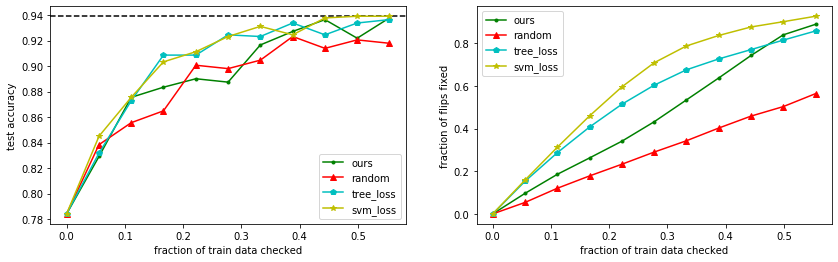

In [7]:
noise_detection(model_type='cb', encoding='leaf_output', dataset='NC17_EvalPart1', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True, flip_frac=0.35, true_label=False)

## MFC18_EvalPart1

train instances: 13936
test instances: 3485
sum before: 2612
ones flipped: 794
zeros flipped: 3386
sum after: 5204
num noisy labels: 4180

Before noise:
model (CatBoostClassifier)
train set acc: 0.987945
train log loss: 0.04816
train auroc: 0.999
test set acc: 0.967575
test log loss: 0.09053
test auroc: 0.990

After noise:
model (CatBoostClassifier)
train set acc: 0.752799
train log loss: 0.51584
train auroc: 0.841
test set acc: 0.907317
test log loss: 0.42162
test auroc: 0.943


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


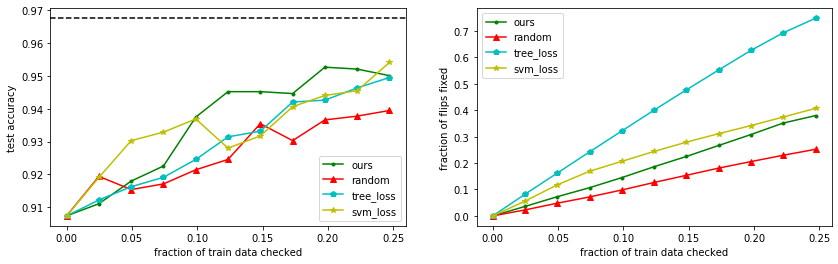

In [8]:
noise_detection(model_type='cb', encoding='leaf_output', dataset='MFC18_EvalPart1', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True, flip_frac=0.3, true_label=False)

## MFC19_EvalPart1

train instances: 12823
test instances: 3206
sum before: 4600
ones flipped: 1635
zeros flipped: 2853
sum after: 5818
num noisy labels: 4488

Before noise:
model (CatBoostClassifier)
train set acc: 0.959760
train log loss: 0.12481
train auroc: 0.993
test set acc: 0.917342
test log loss: 0.19979
test auroc: 0.973

After noise:
model (CatBoostClassifier)
train set acc: 0.735553
train log loss: 0.54932
train auroc: 0.829
test set acc: 0.827511
test log loss: 0.51763
test auroc: 0.891


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


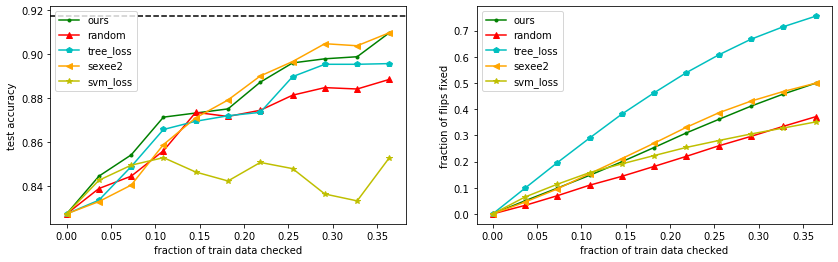

In [11]:
noise_detection(model_type='cb', encoding='leaf_output', dataset='MFC19_EvalPart1', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True, flip_frac=0.35, true_label=False, ours2=True)

## Breast

train instances: 455
test instances: 114
sum before: 285
ones flipped: 97
zeros flipped: 62
sum after: 250
num noisy labels: 159

Before noise:
model (CatBoostClassifier)
train set acc: 1.000000
train log loss: 0.00840
train auroc: 1.000
test set acc: 0.982456
test log loss: 0.04410
test auroc: 0.999

After noise:
model (CatBoostClassifier)
train set acc: 1.000000
train log loss: 0.18163
train auroc: 1.000
test set acc: 0.745614
test log loss: 0.50097
test auroc: 0.830


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


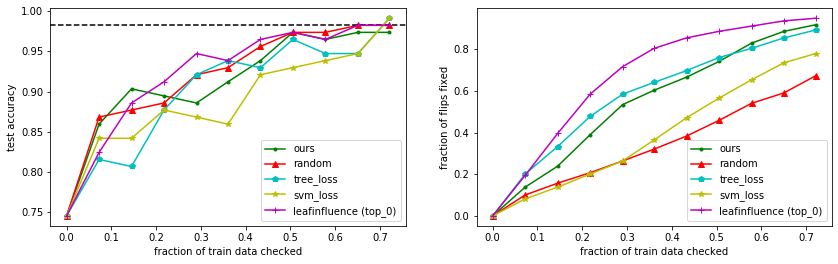

In [3]:
noise_detection(model_type='cb', encoding='tree_output', dataset='breast', n_estimators=100, random_state=1, inf_k=0,
                data_dir=data_dir, svm_loss=True, flip_frac=0.35)